# HELP - Bootes Master List Creation

This notebook presents the creation of the HELP master list on the Bootes field. This field was originally ingested into HeDAM based on a masterlist produced by Eduardo Gonzales-Solares. Ken Duncan subsequently retrieved Michael Brown's precompiled masterlist for the Bootes field and therefore this notebook only contains some simple naming changes and astrometry correction. The original catalogue is described in DMU_0.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict, Counter
import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, hstack, Table, vstack
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates, nb_merge_dist_plot
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, gen_help_id

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "bootes_ra"
DEC_COL = "botes_dec"

## I - Column selection

In [4]:
#imported_columns = OrderedDict({
#        "objID": "ps1_id",
#        "raMean": "ps1_ra",
#        "decMean": "ps1_dec",
#
#    })


i_catalogue = Table.read("../../dmu0/dmu0_Bootes_Brown/data/Bootes_merged_Icorr_2014a_all_ap2_07112017.fits") #[list(imported_columns)]
irac_i2_catalogue = Table.read("../../dmu0/dmu0_Bootes_Brown/data/bootes_merged_ch2corr_2014a_all_ap2_07112017.fits")
#for column in imported_columns:
#    catalogue[column].name = imported_columns[column]

#epoch = 2012

# Clean table metadata
#catalogue.meta = None

In [5]:
i_catalogue['ALPHA_J2000'].name = "ra"
i_catalogue['DELTA_J2000'].name = "dec"
i_catalogue['ra'].unit = u.deg
i_catalogue['dec'].unit = u.deg

In [6]:
i_catalogue[:10].show_in_notebook()

idx,id,ra,dec,FLAG_DEEP,CLASS_STAR,IMAFLAGS,SEGFLAGS,m_ap_lbc_u,merr_ap_lbc_u,f_ap_lbc_u,ferr_ap_lbc_u,m_ap_mosaic_bw,merr_ap_mosaic_bw,f_ap_mosaic_bw,ferr_ap_mosaic_bw,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_prime90_z,merr_ap_prime90_z,f_ap_prime90_z,ferr_ap_prime90_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbc_y,merr_ap_lbc_y,f_ap_lbc_y,ferr_ap_lbc_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_onis_k,merr_ap_onis_k,f_ap_onis_k,ferr_ap_onis_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_ch1,merr_ap_irac_ch1,f_ap_irac_ch1,ferr_ap_irac_ch1,m_ap_irac_ch2,merr_ap_irac_ch2,f_ap_irac_ch2,ferr_ap_irac_ch2,m_ap_irac_ch3,merr_ap_irac_ch3,f_ap_irac_ch3,ferr_ap_irac_ch3,m_ap_irac_ch4,merr_ap_irac_ch4,f_ap_irac_ch4,ferr_ap_irac_ch4
,,deg,deg,,,,,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy,,,uJy,uJy
0,1,216.473863,32.2825963,0,0.64,1,0,25.3294,-99.0,0.0765911,0.0957339,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.6871,0.1773,1.21658,0.198666,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.544,-99.0,0.114963,0.636561,23.1026,-99.0,0.120575,0.981891,21.0877,-99.0,3.42072,4.95589,20.3206,-99.0,8.53047,9.24751
1,2,216.6176098,32.2827433,0,0.66,1,21,25.2766,-99.0,0.0674122,0.107004,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.563,0.1801,1.36389,0.22624,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.428,-99.0,1.85771,1.01104,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.7807,-99.0,0.560893,1.12133,23.5937,-99.0,-0.841274,1.08362,21.172,-99.0,-1.24887,6.79294,21.0885,-99.0,-4.71642,9.01942
2,3,216.6229261,32.2827587,0,0.95,1,0,27.024,-99.0,-0.172496,0.11439,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.6079,0.2358,1.30864,0.284211,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.4042,0.3129,3.96587,1.14293,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.0248,-99.0,0.0582638,1.09041,23.3361,-99.0,-0.450296,1.06563,21.9414,-99.0,-6.4583,6.26595,20.8749,-99.0,-1.74025,8.9797
3,4,216.6170473,32.2827598,0,0.81,1,0,26.4913,-99.0,-0.124479,0.108206,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.3939,0.1541,1.59375,0.226203,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.9429,0.4547,2.41446,1.01116,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.6654,-99.0,0.97427,1.07169,23.2841,-99.0,-0.29979,1.0316,21.5816,-99.0,-5.15037,6.80526,21.1196,-99.0,-4.89432,8.92056
4,5,216.6101975,32.2827674,0,0.94,1,2,25.7669,-99.0,-0.0370969,0.108127,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.5912,0.1569,1.32893,0.192043,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.9563,0.3442,2.38506,0.756112,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.7029,-99.0,0.855066,1.07846,22.7077,-99.0,0.705761,1.14639,21.3186,-99.0,-5.7884,8.28326,20.5633,-99.0,2.94478,9.33336
5,6,216.5465545,32.2827939,0,0.71,1,10,24.7405,0.2036,0.461125,0.0864713,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.0635,0.0782635,2.16063,0.155745,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.7609,-99.0,-0.359235,0.74796,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,21.911,0.1264,6.24596,0.727147,22.2414,0.2474,4.60742,1.04986,21.1104,-99.0,-0.332322,6.69488,20.5462,-99.0,8.46004,6.74708
6,7,216.6220666,32.2827948,0,0.96,1,0,25.4731,-99.0,0.00950819,0.112663,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,23.5671,0.2271,1.35875,0.284206,-99.0,-99.0,-99.0,

In [7]:
irac_i2_catalogue['ALPHA_J2000'].unit = u.deg
irac_i2_catalogue['DELTA_J2000'].unit = u.deg

In [8]:
irac_i2_catalogue[:10].show_in_notebook()

idx,id,ALPHA_J2000,DELTA_J2000,IMAFLAGS,SEGFLAGS,m_ap_lbc_u,merr_ap_lbc_u,f_ap_lbc_u,ferr_ap_lbc_u,m_ap_mosaic_bw,merr_ap_mosaic_bw,f_ap_mosaic_bw,ferr_ap_mosaic_bw,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_prime90_z,merr_ap_prime90_z,f_ap_prime90_z,ferr_ap_prime90_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbc_y,merr_ap_lbc_y,f_ap_lbc_y,ferr_ap_lbc_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_onis_k,merr_ap_onis_k,f_ap_onis_k,ferr_ap_onis_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_ch1,merr_ap_irac_ch1,f_ap_irac_ch1,ferr_ap_irac_ch1,m_ap_irac_ch2,merr_ap_irac_ch2,f_ap_irac_ch2,ferr_ap_irac_ch2,m_ap_irac_ch3,merr_ap_irac_ch3,f_ap_irac_ch3,ferr_ap_irac_ch3,m_ap_irac_ch4,merr_ap_irac_ch4,f_ap_irac_ch4,ferr_ap_irac_ch4
,,deg,deg,,,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy
0,1,217.5665371,32.117202,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,21.8227566382,0.3133,6.77481350724,1.95493994077,-99.0,-99.0,-99.0,-99.0,19.3435866264,-99.0,31.6411819493,17.4097925571
1,2,216.1924704,32.1071896,6,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,20.7889566382,0.0947,17.5556674154,1.53123907719,-99.0,-99.0,-99.0,-99.0,20.1495976355,-99.0,5.51636123756,13.0590683324
2,3,216.2097384,32.1080726,4,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,21.9249566382,0.2392,6.16619627748,1.35848297506,-99.0,-99.0,-99.0,-99.0,20.1281753971,-99.0,11.5327452293,10.3660594718
3,4,216.2048572,32.1082895,6,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.4816566382,0.4211,3.69264318776,1.4321821816,-99.0,-99.0,-99.0,-99.0,20.7232067928,-99.0,-6.76725743805,12.7094542684
4,5,216.592738,32.1131399,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,22.0409566382,0.3882,5.54137249505,1.98129231866,-99.0,-99.0,-99.0,-99.0,20.1004531708,-99.0,-1.69688612318,17.3980901074
5,6,216.5893936,32.1132923,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,20.9708566382,0.1276,14.8476371197,1.74495286071,-99.0,-99.0,-99.0,-99.0,19.5326385559,-99.0,15.9430973557,19.9483978362
6,7,216.6887551,32.1133444,5,0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-9

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
"""SORT_COLS = ['merr_ap_gpc1_r', 'merr_ap_gpc1_g', 'merr_ap_gpc1_i', 'merr_ap_gpc1_z', 'merr_ap_gpc1_y']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))"""

'SORT_COLS = [\'merr_ap_gpc1_r\', \'merr_ap_gpc1_g\', \'merr_ap_gpc1_i\', \'merr_ap_gpc1_z\', \'merr_ap_gpc1_y\']\nFLAG_NAME = \'ps1_flag_cleaned\'\n\nnb_orig_sources = len(catalogue)\n\ncatalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)\n\nnb_sources = len(catalogue)\n\nprint("The initial catalogue had {} sources.".format(nb_orig_sources))\nprint("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))\nprint("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))'

## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [10]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Bootes.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

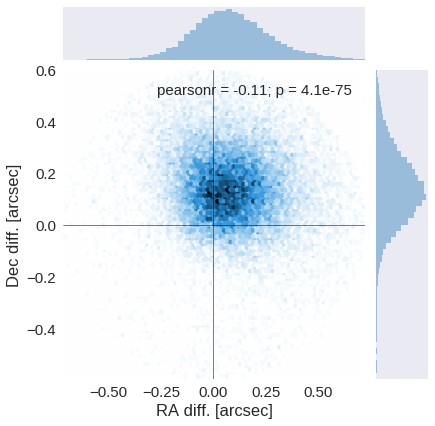

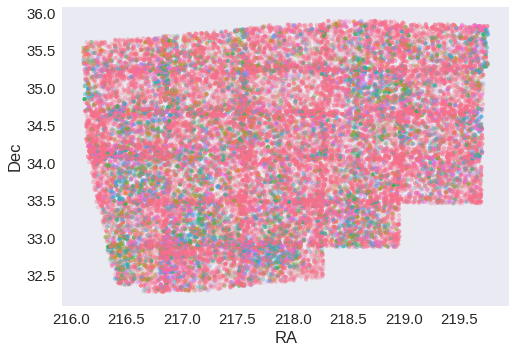

In [11]:
nb_astcor_diag_plot(i_catalogue["ra"], i_catalogue["dec"], 
                    gaia_coords.ra, gaia_coords.dec)

In [12]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(i_catalogue["ra"], i_catalogue["dec"]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.0735978168904694 arcsec
Dec correction: -0.12698051759514328 arcsec


In [13]:
i_catalogue["ra"] = i_catalogue["ra"] + delta_ra.to(u.deg)
i_catalogue["dec"] = i_catalogue["dec"] + delta_dec.to(u.deg)

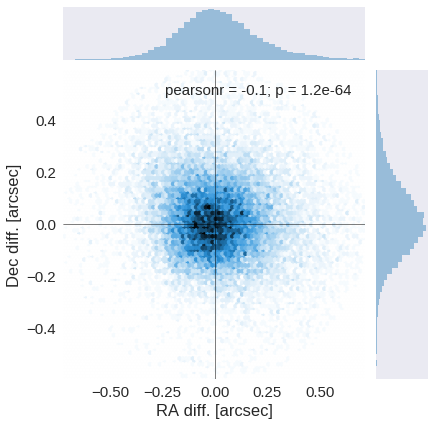

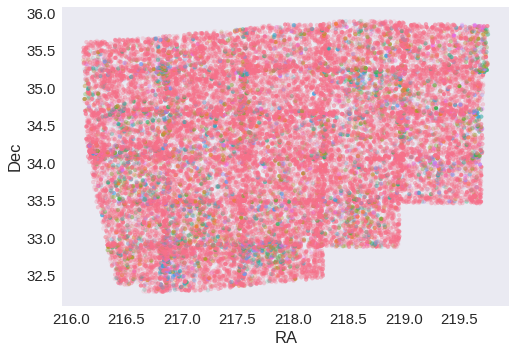

In [14]:
nb_astcor_diag_plot(i_catalogue["ra"], i_catalogue["dec"], 
                    gaia_coords.ra, gaia_coords.dec)

We then correct the other catalogue

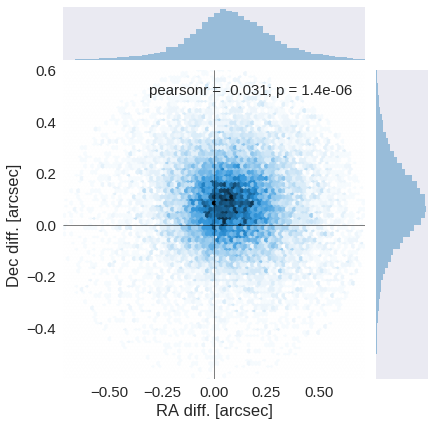

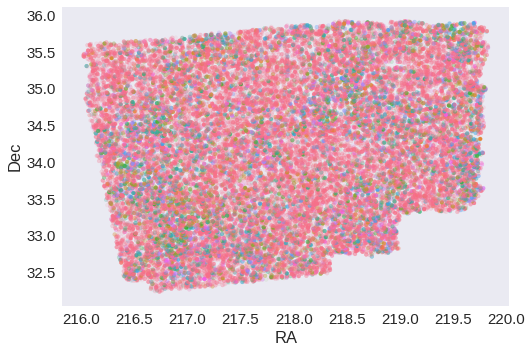

In [15]:
nb_astcor_diag_plot(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"], 
                    gaia_coords.ra, gaia_coords.dec)

In [16]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07916888162640134 arcsec
Dec correction: -0.08063874360573209 arcsec


In [17]:
irac_i2_catalogue["ALPHA_J2000"] = irac_i2_catalogue["ALPHA_J2000"] + delta_ra.to(u.deg)
irac_i2_catalogue["DELTA_J2000"] = irac_i2_catalogue["DELTA_J2000"] + delta_dec.to(u.deg)

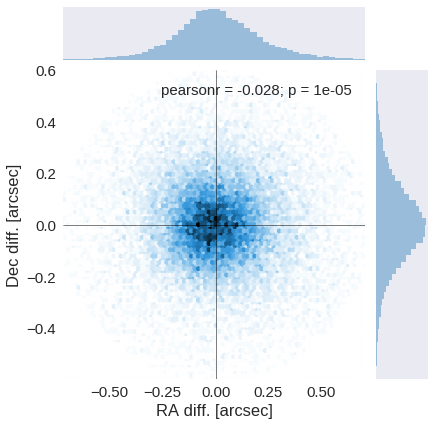

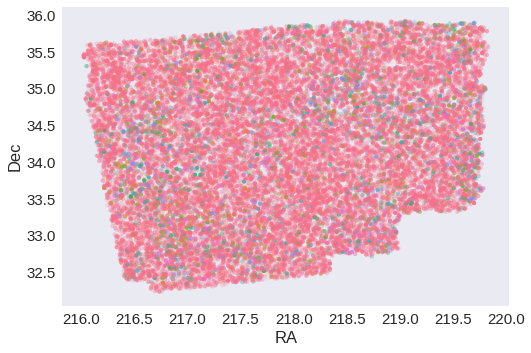

In [18]:
nb_astcor_diag_plot(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"], 
                    gaia_coords.ra, gaia_coords.dec)

# Merging

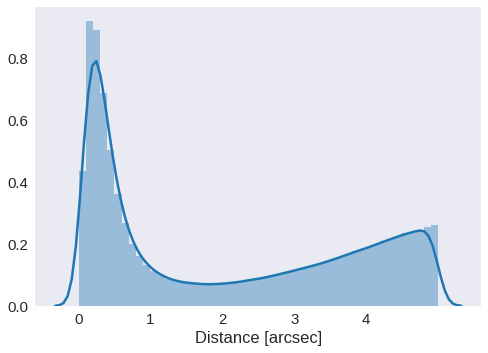

In [19]:
nb_merge_dist_plot(
    SkyCoord(i_catalogue['ra'], i_catalogue['dec']),
    SkyCoord(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"] )
)

In [20]:
radius = 1.0*u.arcsec
coords_1 = SkyCoord(i_catalogue['ra'], i_catalogue['dec'])

coords_2 = SkyCoord(irac_i2_catalogue["ALPHA_J2000"], irac_i2_catalogue["DELTA_J2000"])

# Search for sources in second catalogue matching the sources in the first
# one.
idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

# We want to flag the possible mis-associations, i.e. the sources in each
# catalogue that are associated to several sources in the other one, but
# also all the sources that are associated to a problematic source in the
# other catalogue (e.g. if two sources in the first catalogue are
# associated to the same source in the second catalogue, they must be
# flagged as potentially problematic).
#
# Search for duplicate associations
toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
# Flagging the sources associated to duplicates
dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
toflag_idx_1 = np.unique(np.concatenate(
    (toflag_idx_1, idx_1[dup_associated_in_idx1])
))
toflag_idx_2 = np.unique(np.concatenate(
    (toflag_idx_2, idx_2[dup_associated_in_idx2])
))

# Adding the flags to the catalogue.  In the second catalogue, the column
# is named "flag_merged_2" and will be combined to the flag_merged column
# one the merge is done.
try:
    i_catalogue["flag_merged"] |= np.in1d(np.arange(len(i_catalogue), dtype=int),
                                        toflag_idx_1)
except KeyError:
    i_catalogue.add_column(Column(
        data=np.in1d(np.arange(len(i_catalogue), dtype=int), toflag_idx_1),
        name="flag_merged"
    ))
irac_i2_catalogue.add_column(Column(
    data=np.in1d(np.arange(len(irac_i2_catalogue), dtype=int), toflag_idx_2),
       name="flag_merged_2"
))

# Now that we have flagged the maybe spurious associations, we want to
# associate each source of each catalogue to at most one source in the
# other one.

# We sort the indices by the distance to take the nearest counterparts in
# the following steps.
sort_idx = np.argsort(d2d)
idx_1 = idx_1[sort_idx]
idx_2 = idx_2[sort_idx]

# These array will contain the indexes of the matching sources in both
# catalogues.
match_idx_1 = np.array([], dtype=int)
match_idx_2 = np.array([], dtype=int)

while len(idx_1) > 0:

    both_first_idx = np.sort(np.intersect1d(
         np.unique(idx_1, return_index=True)[1],
         np.unique(idx_2, return_index=True)[1],
    ))

    new_match_idx_1 = idx_1[both_first_idx]
    new_match_idx_2 = idx_2[both_first_idx]

    match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
    match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

    # We remove the matching sources in both catalogues.
    to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
    idx_1 = idx_1[~to_remove]
    idx_2 = idx_2[~to_remove]

# Indices of un-associated object in both catalogues.
unmatched_idx_1 = np.delete(np.arange(len(i_catalogue), dtype=int),match_idx_1)
unmatched_idx_2 = np.delete(np.arange(len(irac_i2_catalogue), dtype=int),match_idx_2)

# Sources only in cat_1
only_in_cat_1 = i_catalogue[unmatched_idx_1]

# Sources only in cat_2
only_in_cat_2 = irac_i2_catalogue[unmatched_idx_2]
# We are using the ra and dec columns from cat_2 for the position.
only_in_cat_2["ALPHA_J2000"].name = "ra"
only_in_cat_2["DELTA_J2000"].name = "dec"

# Where we have an association we take the values from the i selected catalogue.
both_in_cat_1_and_cat_2 = i_catalogue[match_idx_1] #hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
# We don't need the positions from the second catalogue anymore.
#both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

# Logging the number of rows
print("There are {} sources only in the first catalogue".format(len(only_in_cat_1)))
print("There are {} sources only in the second catalogue".format(len(only_in_cat_2)))
print("There are {} sources in both catalogues".format(len(both_in_cat_1_and_cat_2)))

merged_catalogue = vstack([only_in_cat_1,  both_in_cat_1_and_cat_2,
                               only_in_cat_2])

# When vertically stacking the catalogues, some values in the flag columns
# are masked because they did not exist in the catalogue some row originate
# from. We must set them to the appropriate value.
for colname in merged_catalogue.colnames:
    if 'flag' in colname:
        merged_catalogue[colname][merged_catalogue[colname].mask] = False

# We combined the flag_merged flags
merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
merged_catalogue.remove_column('flag_merged_2')

There are 1580405 sources only in the first catalogue
There are 185203 sources only in the second catalogue
There are 486485 sources in both catalogues


In [21]:
# Replace -99 values
for col in merged_catalogue.colnames:
    if col.startswith('m_'):
        errcol = "merr{}".format(col[1:])
        merged_catalogue[col][merged_catalogue[col] < -90.] = np.nan
        merged_catalogue[errcol][merged_catalogue[errcol] < -90.] = np.nan
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        merged_catalogue[col][merged_catalogue[col] < -90.] = np.nan
        merged_catalogue[errcol][merged_catalogue[errcol] < -90.] = np.nan
        


/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


In [22]:
merged_catalogue['CLASS_STAR'].name = 'stellarity'
merged_catalogue.remove_columns(['FLAG_DEEP', 'IMAFLAGS', 'SEGFLAGS'])

In [23]:
merged_catalogue[:10].show_in_notebook()

idx,id,ra,dec,stellarity,m_ap_lbc_u,merr_ap_lbc_u,f_ap_lbc_u,ferr_ap_lbc_u,m_ap_mosaic_bw,merr_ap_mosaic_bw,f_ap_mosaic_bw,ferr_ap_mosaic_bw,m_ap_mosaic_r,merr_ap_mosaic_r,f_ap_mosaic_r,ferr_ap_mosaic_r,m_ap_mosaic_i,merr_ap_mosaic_i,f_ap_mosaic_i,ferr_ap_mosaic_i,m_ap_prime90_z,merr_ap_prime90_z,f_ap_prime90_z,ferr_ap_prime90_z,m_ap_suprime_z,merr_ap_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_ap_lbc_y,merr_ap_lbc_y,f_ap_lbc_y,ferr_ap_lbc_y,m_ap_newfirm_j,merr_ap_newfirm_j,f_ap_newfirm_j,ferr_ap_newfirm_j,m_ap_newfirm_h,merr_ap_newfirm_h,f_ap_newfirm_h,ferr_ap_newfirm_h,m_ap_onis_k,merr_ap_onis_k,f_ap_onis_k,ferr_ap_onis_k,m_ap_newfirm_k,merr_ap_newfirm_k,f_ap_newfirm_k,ferr_ap_newfirm_k,m_ap_irac_ch1,merr_ap_irac_ch1,f_ap_irac_ch1,ferr_ap_irac_ch1,m_ap_irac_ch2,merr_ap_irac_ch2,f_ap_irac_ch2,ferr_ap_irac_ch2,m_ap_irac_ch3,merr_ap_irac_ch3,f_ap_irac_ch3,ferr_ap_irac_ch3,m_ap_irac_ch4,merr_ap_irac_ch4,f_ap_irac_ch4,ferr_ap_irac_ch4,flag_merged
,,deg,deg,,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,,mag,uJy,uJy,
0,1,216.473842556,32.2825610276,0.64,25.3294239044,nan,0.0765910670161,0.0957338809967,nan,nan,nan,nan,nan,nan,nan,nan,23.6871490479,0.177300006151,1.21657812595,0.198666423559,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.5439605713,nan,0.114963367581,0.636560559273,23.1025695801,nan,0.120574891567,0.981891393661,21.087720871,nan,3.42071938515,4.95589256287,20.3205661774,nan,8.53046512604,9.24751186371,False
1,2,216.617589356,32.2827080276,0.66,25.2766113281,nan,0.0674121528864,0.107003986835,nan,nan,nan,nan,nan,nan,nan,nan,23.5630474091,0.180099993944,1.36389410496,0.226240366697,nan,nan,nan,nan,nan,nan,nan,nan,22.4279766083,nan,1.85771453381,1.01104068756,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,22.7807235718,nan,0.560892522335,1.12133443356,23.5936756134,nan,-0.841273665428,1.0836161375,21.1719741821,nan,-1.24887311459,6.7929444313,21.0885429382,nan,-4.71642255783,9.01941776276,False
2,3,216.622905656,32.2827234276,0.95,27.0240478516,nan,-0.172495692968,0.114389590919,nan,nan,nan,nan,nan,nan,nan,nan,23.6079463959,0.235799998045,1.30864286423,0.284210830927,nan,nan,nan,nan,nan,nan,nan,nan,22.4041519165,0.312900006771,3.96587443352,1.14293158054,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.0248279572,nan,0.058263849467,1.09040522575,23.336107254,nan,-0.450295627117,1.06562697887,21.9413833618,nan,-6.45829677582,6.26595163345,20.8749294281,nan,-1.74025189877,8.97970199585,False
3,4,216.617026856,32.2827245276,0.81,26.4913158417,nan,-0.124479405582,0.10820645839,nan,nan,nan,nan,nan,nan,nan,nan,23.3939495087,0.154100000858,1.59374952316,0.226203039289,nan,nan,nan,nan,nan,nan,nan,nan,22.942949295,0.454699993134,2.41445994377,1.0111618042,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,22.6654319763,nan,0.97426956892,1.07168781757,23.284116745,nan,-0.299789994955,1.03159999847,21.5815544128,nan,-5.15036535263,6.80525779724,21.119594574,nan,-4.89432287216,8.92055988312,False
4,5,216.610177056,32.2827321276,0.94,25.7669200897,nan,-0.0370969176292,0.108126543462,nan,nan,nan,nan,nan,nan,nan,nan,23.5912475586,0.156900003552,1.32892560959,0.192043378949,nan,nan,nan,nan,nan,nan,nan,nan,22.9562511444,0.344199985266,2.3850607872,0.756111741066,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,22.7028656006,nan,0.855065524578,1.07846343517,22.7077236176,nan,0.705760955811,1.14639258385,21.3186416626,nan,-5.78839588165,8.28325557709,20.563287735,nan,2.94477701187,9.333360672,False
5,7,216.622046156,32.2827595276,0.96,25.4730987549,nan,0.00950819067657,0.112662665546,nan,nan,nan,nan,nan,nan,nan,nan,23.5671482086,0.227099999785,1.3587526083,0.284206002951,nan,nan,nan,nan,nan,nan,nan,nan,22.439414978,nan,1.61116075516,1.11398911476,nan,nan,nan,nan,nan,nan,nan

## IV - Flagging Gaia objects

In [24]:
merged_catalogue.add_column(
    gaia_flag_column(SkyCoord(merged_catalogue["ra"], merged_catalogue["dec"]), 2012, gaia)
)

In [25]:
GAIA_FLAG_NAME = "bootes_flag_gaia"

merged_catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(merged_catalogue[GAIA_FLAG_NAME] > 0)))

38129 sources flagged.



# V - Adding HELP unique identifiers and field columns

In [26]:
merged_catalogue.add_column(Column(gen_help_id(merged_catalogue['ra'], merged_catalogue['dec']),
                                   name="help_id"))
merged_catalogue.add_column(Column(np.full(len(merged_catalogue), "Bootes", dtype='<U18'),
                                   name="field"))

In [27]:
# Check that the HELP Ids are unique
if len(merged_catalogue) != len(np.unique(merged_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

The HELP IDs are not unique!!!


In [ ]:
#merged_catalogue['help_id',  'id'].write(
#    "{}/master_list_cross_ident_bootes{}.fits".format(OUT_DIR, SUFFIX))
#merged_catalogue.remove_columns(['id'])

# VI - Saving to disk

In [29]:
merged_catalogue.write("{}/master_catalogue_bootes{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)